# **Fine-tune SigLIP and friends for multi-label image classification**

In this notebook, I'll show how one can fine-tune any pre-trained vision model from the Transformers library for multi-label image classification.

refference : https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SigLIP/Fine_tuning_SigLIP_and_friends_for_multi_label_image_classification.ipynb

## **Set-up environment**

In [1]:
!pip install --upgrade transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 108.0 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import cv2
import random
import torch
import numpy as np

from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

## **Data preprocessing**

In [4]:
#splite the training and testing path

train_size = 0.8
paths = []
path_to_subset = '/kaggle/input/apparel-dataset'
for folder in os.listdir(path_to_subset):

    for image in os.listdir(os.path.join(path_to_subset, folder)):
        path_to_image = os.path.join(path_to_subset, folder, image)

        #check image none or not none
        img = cv2.imread(path_to_image)
        if img is not None:
          paths.append( path_to_image)

paths = sorted(paths)
paths[0]
random.shuffle(paths)
assert 0.0 < train_size <= 1.0
thresh = round(len(paths) * train_size)
train_paths = paths[:thresh]
test_paths = paths[thresh:]
print(train_paths[0], test_paths[1])

/kaggle/input/apparel-dataset/red_shirt/72.jpg /kaggle/input/apparel-dataset/white_shoes/40.jpg


In [5]:
print("show sample of training path ",train_paths[0:5])
print("Number of training data : ",len(train_paths))
print("Number of val data : ", len(test_paths))

show sample of training path  ['/kaggle/input/apparel-dataset/red_shirt/72.jpg', '/kaggle/input/apparel-dataset/green_shoes/53.jpg', '/kaggle/input/apparel-dataset/red_shirt/302.jpg', '/kaggle/input/apparel-dataset/pink_skirt/000022.jpg', '/kaggle/input/apparel-dataset/white_dress/254.jpg']
Number of training data :  12936
Number of val data :  3234


In [6]:
#Label and classes extraction
def labels(root):
  classes=[]
  lab=[]
  labels=[]
  for idx in range(len(root)):
    # get image
    image_path =root[idx]

    # get labels
    label = image_path.split(os.path.sep)[-2].split('_')
    lab.append(label)

  mlb = MultiLabelBinarizer()
  labels = mlb.fit_transform(lab)
  classes = mlb.classes_

  return labels,classes

In [7]:
#Show label and classes
m_labels,classes=labels(train_paths)
print("labels encode :",m_labels)
print("Class Names :",classes)

labels encode : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
Class Names : ['black' 'blue' 'brown' 'dress' 'green' 'hoodie' 'pants' 'pink' 'red'
 'shirt' 'shoes' 'shorts' 'silver' 'skirt' 'suit' 'white' 'yellow']


In [8]:
#Id to label and label to id for fine tune the model
id2label = {id: label for id, label in enumerate(classes)}
label2id = {v: k for k, v in id2label.items()}
print(id2label)
print(label2id)

{0: 'black', 1: 'blue', 2: 'brown', 3: 'dress', 4: 'green', 5: 'hoodie', 6: 'pants', 7: 'pink', 8: 'red', 9: 'shirt', 10: 'shoes', 11: 'shorts', 12: 'silver', 13: 'skirt', 14: 'suit', 15: 'white', 16: 'yellow'}
{'black': 0, 'blue': 1, 'brown': 2, 'dress': 3, 'green': 4, 'hoodie': 5, 'pants': 6, 'pink': 7, 'red': 8, 'shirt': 9, 'shoes': 10, 'shorts': 11, 'silver': 12, 'skirt': 13, 'suit': 14, 'white': 15, 'yellow': 16}


## **Create PyTorch Dataset**

In [9]:
class MultiLabelDataset(Dataset):
  def __init__(self, root, transform,labels):
    self.root = root
    self.transform = transform
    self.labels=labels

  def __getitem__(self, idx):
    # get image
    image_path = self.root[idx]
    image = Image.open(image_path).convert("RGB")

    # prepare image for the model
    pixel_values = self.transform(image)

    # get labels
    label = self.labels[idx].astype(np.float32)

    # turn into PyTorch tensor
    label = torch.from_numpy(label)

    return pixel_values,label


  def __len__(self):
    return len(self.root)

## **Model Load**

In [10]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

#select the pretraining model
model_id = "google/vit-base-patch16-224-in21k" # "google/siglip-so400m-patch14-384"

processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(model_id, problem_type="multi_label_classification", id2label=id2label,label2id=label2id)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [11]:
#show processing details in pre training model
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# get appropriate size, mean and std based on the image processor
size = processor.size["height"]
mean = processor.image_mean
std = processor.image_std

transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])


#add the dataset to pytorch dataset
train_dataset = MultiLabelDataset(root=train_paths, transform=transform,labels=m_labels)


## **Show samples**

In [13]:
pixel_values, labels = train_dataset[12]
print(pixel_values.shape)

torch.Size([3, 224, 224])


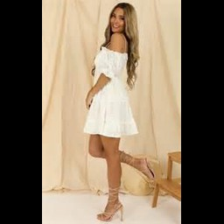

In [14]:
unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [15]:
print("label ID :",labels)
s=torch.nonzero(labels).squeeze().tolist()
print(s)

label ID : tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
[3, 15]


## **Create PyTorch DataLoader**

In [19]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.stack([item[1] for item in batch])
    return data, target

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16, shuffle=True)

In [20]:
batch = next(iter(train_dataloader))
print(batch)

(tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, 

In [21]:
print(batch[0].shape)
print(batch[1].shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 17])


### **Verify initial loss**

In [22]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


outputs = model(pixel_values=batch[0].to(device), labels=batch[1].to(device))

In [23]:
outputs.loss

tensor(0.7005, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## **Training the model**

In [24]:
# handy utility I found at https://github.com/wenwei202/pytorch-examples/blob/ecbb7beb0fac13133c0b09ef980caf002969d315/imagenet/main.py#L296
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
from torch.optim import AdamW
from tqdm.auto import tqdm

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

losses = AverageMeter()

model.train()
for epoch in range(5):  # loop over the dataset multiple times
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(
            pixel_values=pixel_values.to(device),
            labels=labels.to(device),
        )

        # calculate gradients
        loss = outputs.loss
        losses.update(loss.item(), pixel_values.size(0))
        loss.backward()

        # optimization step
        optimizer.step()

        if idx % 100 == 0:
            print('Epoch: [{0}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, loss=losses,))

  0%|          | 0/809 [00:00<?, ?it/s]

Epoch: [0]	Loss 0.2493 (0.2493)	
Epoch: [0]	Loss 0.1819 (0.2084)	
Epoch: [0]	Loss 0.1416 (0.1879)	
Epoch: [0]	Loss 0.1330 (0.1718)	
Epoch: [0]	Loss 0.1041 (0.1581)	
Epoch: [0]	Loss 0.0866 (0.1464)	
Epoch: [0]	Loss 0.0803 (0.1364)	
Epoch: [0]	Loss 0.0715 (0.1278)	
Epoch: [0]	Loss 0.0711 (0.1203)	


  0%|          | 0/809 [00:00<?, ?it/s]

Epoch: [1]	Loss 0.0531 (0.1197)	
Epoch: [1]	Loss 0.0502 (0.1124)	
Epoch: [1]	Loss 0.0482 (0.1060)	
Epoch: [1]	Loss 0.0607 (0.1003)	
Epoch: [1]	Loss 0.0515 (0.0951)	
Epoch: [1]	Loss 0.0303 (0.0904)	
Epoch: [1]	Loss 0.0266 (0.0861)	
Epoch: [1]	Loss 0.0508 (0.0825)	
Epoch: [1]	Loss 0.0186 (0.0791)	


  0%|          | 0/809 [00:00<?, ?it/s]

Epoch: [2]	Loss 0.0251 (0.0788)	
Epoch: [2]	Loss 0.0191 (0.0754)	
Epoch: [2]	Loss 0.0186 (0.0723)	
Epoch: [2]	Loss 0.0144 (0.0695)	
Epoch: [2]	Loss 0.0163 (0.0668)	
Epoch: [2]	Loss 0.0118 (0.0645)	
Epoch: [2]	Loss 0.0133 (0.0623)	
Epoch: [2]	Loss 0.0101 (0.0602)	
Epoch: [2]	Loss 0.0107 (0.0584)	


  0%|          | 0/809 [00:00<?, ?it/s]

Epoch: [3]	Loss 0.0109 (0.0583)	
Epoch: [3]	Loss 0.0086 (0.0564)	
Epoch: [3]	Loss 0.0057 (0.0547)	
Epoch: [3]	Loss 0.0074 (0.0531)	
Epoch: [3]	Loss 0.0072 (0.0517)	
Epoch: [3]	Loss 0.0056 (0.0502)	
Epoch: [3]	Loss 0.0051 (0.0489)	
Epoch: [3]	Loss 0.0048 (0.0475)	
Epoch: [3]	Loss 0.0517 (0.0463)	


  0%|          | 0/809 [00:00<?, ?it/s]

Epoch: [4]	Loss 0.0061 (0.0462)	
Epoch: [4]	Loss 0.0059 (0.0450)	
Epoch: [4]	Loss 0.0054 (0.0439)	
Epoch: [4]	Loss 0.0039 (0.0428)	
Epoch: [4]	Loss 0.0038 (0.0418)	
Epoch: [4]	Loss 0.0036 (0.0408)	
Epoch: [4]	Loss 0.0032 (0.0398)	
Epoch: [4]	Loss 0.0026 (0.0390)	
Epoch: [4]	Loss 0.0030 (0.0381)	


### Save Model

In [27]:
import torch

# Assuming 'model' is your PyTorch model
# Save the entire model
torch.save(model, 'fine_tuned_vit-base-patch16-224-in21k.pth')

# Or save only the model state dictionary
torch.save(model.state_dict(), 'fine_tuned_vit-base-patch16-224-in21k_state_dict.pth')

### Load saved model

In [28]:
import torch

# Load the entire model
model_save = torch.load('/kaggle/working/fine_tuned_vit-base-patch16-224-in21k.pth')

# Move the model to the appropriate device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save.to(device)

<ipython-input-28-439be4f36225>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_save = torch.load('/kaggle/working/fine_tuned_vit-base-patch16-224-in21k.pth')


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## **Inference**

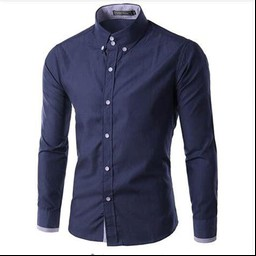

In [54]:
# load image to test on
image = Image.open(test_paths[5])
image

In [55]:
model_save.eval()

# prepare image for the model
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model_save(pixel_values)
  logits = outputs.logits


In [56]:
# turn into probabilities by applying sigmoid
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
print(probs)
# select the probabilities > a certain threshold (e.g. 50%) as predicted
predictions = np.zeros(probs.shape)
print(predictions)
predictions[np.where(probs >= 0.5)] = 1 # turn predicted id's into actual label names
print(predictions)
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

tensor([2.4096e-03, 9.9488e-01, 6.9682e-04, 1.5910e-03, 4.9629e-03, 1.1543e-03,
        2.5834e-03, 9.5767e-04, 1.6388e-03, 9.9436e-01, 1.7991e-03, 1.9121e-03,
        8.5574e-04, 1.3553e-03, 1.2303e-03, 7.9381e-04, 6.5857e-04])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
['blue', 'shirt']


## inference

[('blue', tensor(0.9977)), ('shirt', tensor(0.9825)), ('green', tensor(0.0052))]
[('dress', tensor(0.9958)), ('blue', tensor(0.9796)), ('yellow', tensor(0.0057))]
[('shirt', tensor(0.9942)), ('black', tensor(0.9893)), ('blue', tensor(0.0176))]
[('shoes', tensor(0.9971)), ('white', tensor(0.9917)), ('silver', tensor(0.0074))]
[('white', tensor(0.9927)), ('pants', tensor(0.9716)), ('suit', tensor(0.0273))]
[('dress', tensor(0.9946)), ('red', tensor(0.9861)), ('yellow', tensor(0.0085))]


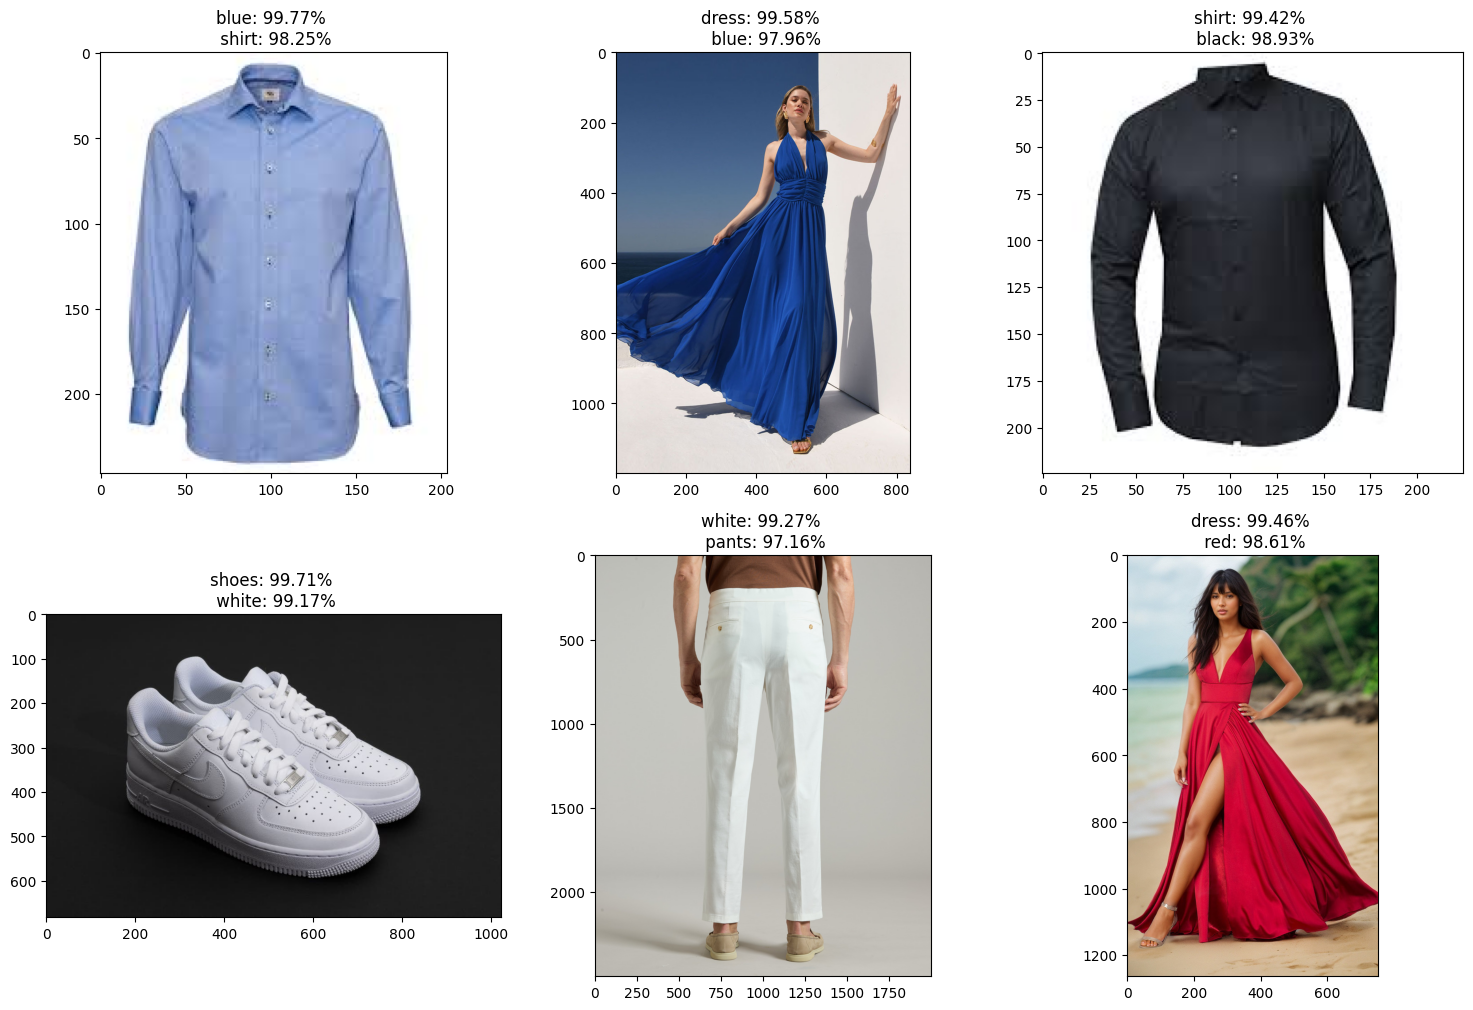

In [64]:
import matplotlib.pyplot as plt
import requests
import cv2

# URLs to images
urls = ["https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBddm7UOg5sD7wgjTLA80F4t0DZ13lBNo-Vw&s",
        "https://www.nashbyna.com/wp-content/uploads/2024/06/nash-01-estella-royal-blue-dress-maxi-mouselina-forema-natashaavloniti-greekdesigner-weddingdresses-bridesmaids-brides-episima-foremata-vradina-foremata-newcollection-copy.jpg"
    ,"https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcROb4c0L_6sFDosrTac4-DQw-_lp2vv8TjKMw&s",
        "https://cdn.thewirecutter.com/wp-content/media/2024/05/white-sneaker-2048px-9338.jpg?auto=webp&quality=75&width=1024",
        "https://www.lanificiocolombo.com/cdn/shop/files/PA00476_TC_A00912_00000_MF.jpg?v=1738490057",
        "https://www.promgirl.com/cdn/shop/files/2aa-POO2Pz-f7RDD_752x1264.jpg?v=1707777108"

       ]
fig = plt.figure(figsize = (15, 15))

for i, url in enumerate(urls):
    plt.subplot(331 + i)

    # Sending request to the URL
    r = requests.get(url, stream = True).raw

    # Reading image, convert it to np array and decode
    image = np.asarray(bytearray(r.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    


    classes=['black', 'blue', 'brown' ,'dress', 'green', 'hoodie', 
             'pants' ,'pink','red','shirt','shoes' ,'shorts' ,'silver', 'skirt', 'suit', 'white', 'yellow']


    # prepare image for the model
    pixel_values = processor(image,return_tensors="pt").pixel_values.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model_save(pixel_values)
        logits = outputs.logits
    
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    #print(probs)
    preds = zip(classes, list(probs))
    preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:3]

    print(preds)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Showing image
    plt.imshow(image[:, :, ::-1])
    plt.title(f'{preds[0][0]}: {round(preds[0][1].item() * 100, 2)}% \n {preds[1][0]}: {round(preds[1][1].item() * 100, 2)}%')

plt.tight_layout()